# **PREDICTIVE MODELLING**

## Objectives

* Develop simple predictive models for clinical outcomes using logistic and linear regression.
* Test hypotheses from earlier stages (e.g., KRAS mutation and mortality risk).
* Evaluate model performance and interpret key features.



## Inputs

* discovery_clean.csv
* validation_clean.csv

## Outputs

* Trained models (in memory or optionally serialized)
* Evaluation metrics: accuracy, AUC, confusion matrix
* Interpretations of feature importance

## Additional Comments

* Modeling will focus on classification (mortality) and optionally regression (e.g., survival time).
* Dataset size constraints will be considered in model choice and interpretation.
* Only interpretable models (logistic, linear regression) will be used.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\petal\\Downloads\\CI-DBC\\vscode-projects\\clinical-survival-analysis\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\petal\\Downloads\\CI-DBC\\vscode-projects\\clinical-survival-analysis'

# Section 1

# Import Libraries and Load Cleaned Data

In [4]:
# 1. Load libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 2. Load cleaned datasets
discovery = pd.read_csv("data/cleaned/discovery_clean.csv")
validation = pd.read_csv("data/cleaned/validation_clean.csv")

# 3. Preview
print("Discovery cohort shape:", discovery.shape)
print("Validation cohort shape:", validation.shape)
display(discovery.head())
display(validation.head())


Discovery cohort shape: (30, 26)
Validation cohort shape: (95, 26)


,PatientID,Specimen date,Dead or Alive,Date of Death,Date of Last Follow Up,Event,Time,sex_M,race_B,race_O,...,Stage_T1N0,Stage_T1NOMX,Stage_T2N0,Stage_T2N1MX,Stage_T2N2MX,Stage_T2NOMX,Stage_pT1pN0,Stage_pT2N2MX,Stage_pT2NOMX,Stage_pT2pN0
0,1,2003-03-17,Dead,2010-02-24,2010-02-24,1,2536,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,2,2003-06-17,Dead,2004-11-12,2004-11-12,1,514,True,False,False,...,False,False,False,False,True,False,False,False,False,False
2,3,2003-09-09,Dead,2009-08-01,2009-08-01,1,2153,False,True,False,...,False,False,False,True,False,False,False,False,False,False
3,4,2003-10-14,Dead,2006-12-29,2006-12-29,1,1172,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,5,2003-12-01,Dead,2004-01-31,2004-01-31,1,61,False,False,False,...,False,False,False,False,False,True,False,False,False,False


,Patient ID,Survival time (days),"Event (death: 1, alive: 0)",Tumor size (cm),Grade,Age,Pack per year,batch,EGFR,KRAS,...,Stage (TNM 8th edition)_IVA,Stage (TNM 8th edition)_Recurrence,Sex_Male,Type.Adjuvant_Chemorad,Type.Adjuvant_No_Adjuvant_Therapy,Type.Adjuvant_XRT,EGFR_status_Wild-type,KRAS_status_Wild-type,Cigarette_Former,Cigarette_Never
0,P109342,2329,1,2.6,3,67,50.0,1,Unknown,Unknown,...,False,False,True,False,True,False,False,False,True,False
1,P124450,2532,0,3.5,3,68,52.5,1,Negative,Negative,...,False,False,False,False,True,False,True,True,True,False
2,P131833,2271,0,2.0,2,80,0.0,1,Negative,Negative,...,False,False,False,False,True,False,True,True,False,True
3,P131888,2193,0,3.0,2,63,47.0,1,Negative,G12C,...,False,False,True,False,True,False,True,False,True,False
4,P131946,2387,0,4.0,2,88,0.0,1,Negative,Negative,...,False,False,False,False,True,False,True,True,False,True


### Data Checks

🔹 Discovery Cohort
* Contains columns like Event, Time, sex_M, race_B, Stage_T1N0, etc.
* Already binary-encoded (e.g., sex_M, race_B, Stage_...), and therefore suitable for regression or classification.

🔹 Validation Cohort
* Cleaned and labeled (e.g., Survival time (days), Event, KRAS, EGFR, Grade, Age, etc.).
* Categorical variables like KRAS are in readable form (Negative, G12C, Unknown, etc.).

Some engineered features already exist (Sex_Male, Stage (TNM 8th edition)_IVA, etc.).

---

# Section 2

# Correlation Matrix (Numerical Variables)

A correlation heatmap created using the validation conhort, focusing on continuous variables such as:
* Survival time (days)
* Tumor size (cm)
* Age
* Pack per year
Categorical and one-hot-encoded features were excluded at this point to keep the matrix readable and meaningful.

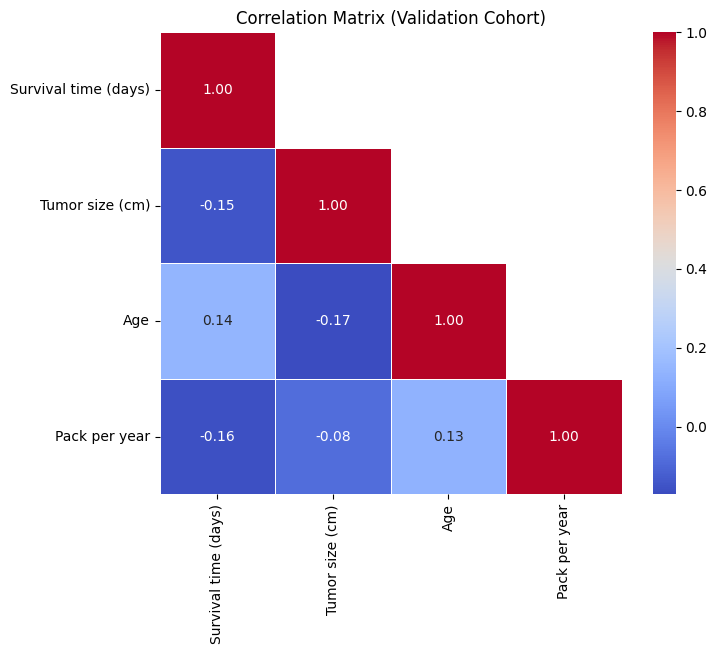

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns
numeric_cols = ['Survival time (days)', 'Tumor size (cm)', 'Age', 'Pack per year']
corr = validation[numeric_cols].corr()

# Create mask for upper triangle *excluding* the diagonal
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation Matrix (Validation Cohort)')
plt.show()



The correlation heatmap above reveals the linear relationships between key continuous variables in the validation cohort. As shown, all correlations are relatively weak (absolute values < 0.20), indicating no strong linear relationships among the features. For example, tumor size and survival time are weakly negatively correlated (r ≈ -0.15), suggesting that larger tumors may be associated with shorter survival, although the effect is minimal. These weak correlations suggest low collinearity among features, which is favorable for subsequent modeling.

---

# Section 3

# Perform Hypothesis Testing (t-Test or ANOVA)

To assess whether survival times significantly differ between tumour stage groups, a one-way ANOVA test was performed. This test compares the means of survival time across the simplified stage categories (Early vs Late) to determine if the observed differences are statistically significant.

In [ ]:
# Create the simplified stage column again
def simplify_stage(stage):
    if pd.isna(stage):
        return 'Unknown'
    elif 'IV' in str(stage):
        return 'Late'
    elif 'I' in str(stage) or 'II' in str(stage):
        return 'Early'
    else:
        return 'Unknown'

validation['Simplified_Stage'] = validation['Stage (TNM 8th edition)'].apply(simplify_stage)


In [ ]:
from scipy.stats import f_oneway

# Filter out unknown stage values if still present
filtered = validation[validation['Simplified_Stage'] != 'Unknown']

# Get survival times for each group
early = filtered[filtered['Simplified_Stage'] == 'Early']['Survival time (days)']
late = filtered[filtered['Simplified_Stage'] == 'Late']['Survival time (days)']

# Perform one-way ANOVA
f_stat, p_val = f_oneway(early, late)

print(f"F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")


---

# Section 4

# Section 4 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create your folder here
  # os.makedirs(name='')
except Exception as e:
  print(e)
